In [1]:
import sys
import pathlib as pl
import shapely
import matplotlib.pyplot as plt
import numpy as np
import flopy

# set up path for loading streamutil
custom_python_path = pl.Path("../python").absolute()
assert custom_python_path.is_dir()
sys.path.append(str(custom_python_path))
import streamutil


Len segment:  6
Len segment:  11
Len segment:  21


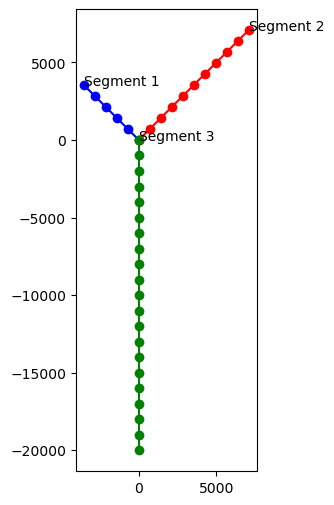

In [2]:

dxl = (5000 ** 2 / 2) ** 0.5
dxr = (10000 ** 2 / 2) ** 0.5
seg1 = [(-dxl, dxl), (0, 0)]
seg2 = [(dxr, dxr), (0, 0)]
seg3 = [(0, 0), (0, -20000)]
sgs = [seg1, seg2, seg3]
upstream_segments = [
    [],
    [],
    [0, 1]
]

# sgsd is the densified line segments ordered from upstream to downstream
reach_length = 1000.
sgsd = [
    streamutil.densify_geometry(sg, reach_length, keep_internal_nodes=False) for sg in sgs
]

fig = plt.figure(figsize=(4, 6))
ax = fig.add_subplot()
ax.set_aspect("equal")

line_symbols = ("bo-", "ro-", "go-", "yo-", "yo-", "bo-", "ro-")
for iseg, (sg, fmt) in enumerate(zip(sgsd, line_symbols)):
    print("Len segment: ", len(sg))
    sa = np.array(sg)
    ax.plot(sa[:, 0], sa[:, 1], fmt)
    xstart, ystart = sg[0]
    ax.text(xstart, ystart, f"Segment {iseg + 1}")

In [3]:
su = streamutil.StreamUtil(sgsd, upstream_segments)
sfr_reach_data = su.get_sfr_reachdata()

ia_seg2reach = su.ia_seg2reach
nsegments = su.nsegments
nreaches = su.nreaches
reach_connectivity = su.reach_connectivity
vertices, cell2d = su.get_vertices_cell2d()

print(f"{nsegments=}")
print(f"{nreaches=}")
print(f"{ia_seg2reach=}")
print(f"{reach_connectivity=}")
print(f"{vertices=}")
print(f"{cell2d=}")


nsegments=3
nreaches=35
ia_seg2reach=array([ 0,  5, 15, 35])
reach_connectivity=[[0, -1], [1, 0, -2], [2, 1, -3], [3, 2, -4], [4, 3, -15], [5, -6], [6, 5, -7], [7, 6, -8], [8, 7, -9], [9, 8, -10], [10, 9, -11], [11, 10, -12], [12, 11, -13], [13, 12, -14], [14, 13, -15], [15, 4, 14, -16], [16, 15, -17], [17, 16, -18], [18, 17, -19], [19, 18, -20], [20, 19, -21], [21, 20, -22], [22, 21, -23], [23, 22, -24], [24, 23, -25], [25, 24, -26], [26, 25, -27], [27, 26, -28], [28, 27, -29], [29, 28, -30], [30, 29, -31], [31, 30, -32], [32, 31, -33], [33, 32, -34], [34, 33]]
vertices=[(0, -3535.5339059327375, 3535.5339059327375, 0.0), (1, -2828.42712474619, 2828.42712474619, 0.0), (2, -2121.3203435596424, 2121.3203435596424, 0.0), (3, -1414.213562373095, 1414.213562373095, 0.0), (4, -707.1067811865473, 707.1067811865473, 0.0), (5, 0.0, 0.0, 0.0), (6, 7071.067811865475, 7071.067811865475, 0.0), (7, 6363.961030678927, 6363.961030678927, 0.0), (8, 5656.85424949238, 5656.85424949238, 0.0), (9, 4949.747

In [4]:
exe_name = "/Users/langevin/langevin/dev/modflow6-fork.git/bin/mf6"
sim_ws = "./beg2022b/mf6"
name = "swfmodel"
sim = flopy.mf6.MFSimulation(
    sim_name=name, 
    version="mf6", 
    exe_name=exe_name, 
    sim_ws=sim_ws,
    memory_print_option='all',
    continue_=True,
)

hr2sec = 60. * 60.
dt = 600 # seconds
perlen = 24 * hr2sec
nstp = perlen / dt
perioddata = [(0.0, 1, 1.0), (perlen, nstp, 1.0)]
tdis = flopy.mf6.ModflowTdis(
    sim,
    time_units="SECONDS",
    nper=len(perioddata),
    perioddata=perioddata
)
ims = flopy.mf6.ModflowIms(
    sim, 
    print_option="all", 
    linear_acceleration="BICGSTAB",
    outer_dvclose=1.e-4,
    inner_dvclose=1.e-4
)
swf = flopy.mf6.ModflowSwf(sim, modelname=name, save_flows=True)

nodes = nreaches
nvert = len(vertices)
slope = 1. / 10000.

# back calculate the stream bottom elevation starting at
# the last reach and working up the y segments
z = np.zeros(nreaches, dtype=float)
zlast = - .5 * reach_length * slope
for ireach in range(nreaches - 1, -1, -1):
    z[ireach] = zlast + slope * reach_length
    zlast = z[ireach]
zlast = z[15]
for ireach in range(4, -1, -1):
    z[ireach] = zlast + slope * reach_length
    zlast = z[ireach]


disl = flopy.mf6.ModflowSwfdisl(
    swf, 
    nodes=nodes, 
    nvert=nvert,
    reach_length=reach_length,
    reach_bottom=z,
    idomain=1, 
    vertices=vertices, 
    cell2d=cell2d,
)

dfw = flopy.mf6.ModflowSwfdfw(
    swf, 
#    central_in_space=True,
    print_flows=True,
    save_flows=True,
    width=40., 
    manningsn=1./80.,
    slope=slope,
    idcxs=0,
)

sto = flopy.mf6.ModflowSwfsto(
    swf,
    save_flows=True,
    steady_state={0: True, 1: False},
    transient={0: False, 1: True},
)

water_depth = 4.0
strt = z + water_depth
ic = flopy.mf6.ModflowSwfic(swf, strt=strt)

# create the cross-section profile using the information
# in Figure 3 of Beg et al. (2022)
xfraction = np.array([0., 0., 10., 15., 25., 30., 40., 40.]) / 40.
height = [40., 10., 10., 0., 0., 10., 10., 40.]
npts = len(height)
mannfraction = npts * [1.]
cxsdata = list(zip(xfraction, height, mannfraction))
cxs = flopy.mf6.ModflowSwfcxs(
    swf,
    nsections=1,
    npoints=npts,
    packagedata=[(0, npts)],
    crosssectiondata=cxsdata,
)

# output control
oc = flopy.mf6.ModflowSwfoc(
    swf,
    budget_filerecord=f"{name}.bud",
    stage_filerecord=f"{name}.stage",
    saverecord=[("STAGE", "ALL"), ("BUDGET", "ALL"), ],
    printrecord=[("STAGE", "LAST"),("BUDGET", "ALL"), ],
)

# construct the inflow hydrograph, which is applied to the
# first reach in segment 1 (0) and the first reach in segment 2 (5)
# time, reach1 (cms)
reach_inflow = [
    (0, 20.),
    (2 * hr2sec, 20),
    (3 * hr2sec, 25),
    (4 * hr2sec, 20),
    (24 * hr2sec, 20),
]
flwlist = [
    [(0,), "reach1"],
    [(5,), "reach1"],
]
flw = flopy.mf6.ModflowSwfflw(
    swf,
    maxbound=len(flwlist),
    print_input=True,
    print_flows=True,
    stress_period_data=flwlist,
)
filename = name + ".flw.ts"
time_series_namerecord = [("reach1")]
interpolation_methodrecord = [("linearend")]
flw.ts.initialize(
    filename=filename,
    timeseries=reach_inflow,
    time_series_namerecord=time_series_namerecord,
    interpolation_methodrecord=interpolation_methodrecord,
)

chd = flopy.mf6.ModflowSwfchd(
    swf,
    maxbound=1,
    print_input=True,
    print_flows=True,
    stress_period_data=[(nreaches - 1, z[-1] + water_depth)]
)

obs_data = {
    f"{name}.obs.csv": [
        ("REACH1", "STAGE", (0,)),
        ("REACH6", "STAGE", (5,)),
        ("REACH16", "STAGE", (15,)),
        ("OUTSEG1", "FLOW-JA-FACE", (4,), (15,)),
        ("OUTSEG2", "FLOW-JA-FACE", (14,), (15,)),
    ],
}
obs_package = flopy.mf6.ModflowUtlobs(
    swf,
    filename=f"{name}.obs",
    digits=10,
    print_input=True,
    continuous=obs_data,
)


sim.write_simulation()
sim.run_simulation()



writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model swfmodel...
    writing model name file...
    writing package disl...
    writing package dfw...
    writing package sto...
    writing package ic...
    writing package cxs...
    writing package oc...
    writing package flw_0...
    writing package ts_0...
    writing package chd_0...
    writing package obs_0...
FloPy is using the following executable to run the model: ../../../../../modflow6-fork.git/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.5.0.dev0 (preliminary) 07/13/2023
                               ***DEVELOP MODE***

        MODFLOW 6 compiled Jan  2 2024 12:43:12 with GCC version 13.2.0

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The 

(True, [])

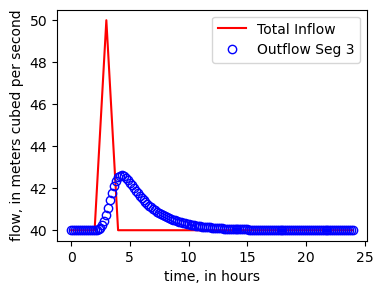

In [5]:
fpth = f"{sim_ws}/swfmodel.bud"
budobj = flopy.utils.binaryfile.CellBudgetFile(fpth, precision="double")
flowja = budobj.get_data(text="FLOW-JA-FACE")
qstorage = budobj.get_data(text="STORAGE")
qflw = budobj.get_data(text="FLW")
qchd = budobj.get_data(text="CHD")

qoutflow = []
times = np.array(budobj.times)
for ra in qchd:
    q = - ra[0]["q"]
    qoutflow.append(q)

qinflow0 = []
qinflow1 = []
qinflow = []
for ra in qflw:
    q0 = ra[0]["q"]
    qinflow0.append(q0)
    q1 = ra[1]["q"]
    qinflow1.append(q1)
    qinflow.append(q0 + q1)
    
# plot upstream and downstream flow
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(times / 60. / 60., qinflow, 'r-', label="Total Inflow")
ax.plot(times / 60. / 60., qoutflow, 'bo', mfc="none", label="Outflow Seg 3")
#ax.set_xlim(0, 10.)
#ax.set_ylim(19, 26)
plt.xlabel("time, in hours")
plt.ylabel("flow, in meters cubed per second")
plt.legend()


Text(0.5, 0, 'time, in hours')

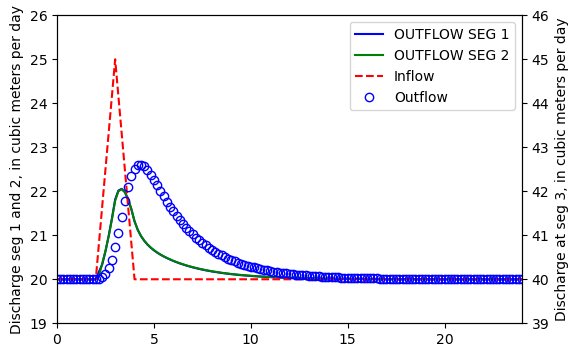

In [6]:
fpth = f"{sim_ws}/{name}.obs.csv"
obsvals = np.genfromtxt(fpth, names=True, delimiter=",")

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)

times = obsvals["time"] / 60. / 60.
ln1 = ax.plot(times, -obsvals[f"OUTSEG1"], "b-", label=f"OUTFLOW SEG 1")
ln2 = ax.plot(times, -obsvals[f"OUTSEG2"], "g-", label=f"OUTFLOW SEG 2")
ax.set_xlim(0, 24.)
ax.set_ylim(19, 26)
ax.set_ylabel("Discharge seg 1 and 2, in cubic meters per day")

ax2 = ax.twinx()
times = np.array(budobj.times)
ln3 = ax.plot(times / 60. / 60., qinflow0, 'r--', label="Inflow")
ln4 = ax2.plot(times / 60. / 60., qoutflow, 'bo', mfc="none", label="Outflow")
ax2.set_ylim(39, 46)
ax2.set_ylabel("Discharge at seg 3, in cubic meters per day")

lns = ln1 + ln2 + ln3 + ln4
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

plt.xlabel("time, in hours")
#plt.ylabel("flow, in square meters per second")
#plt.legend()


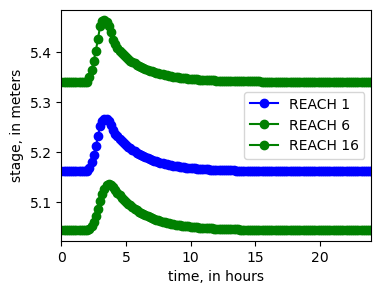

In [7]:
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)

times = obsvals["time"] / 60. / 60.
ax.plot(times, obsvals[f"REACH1"], "bo-", label=f"REACH 1")
ax.plot(times, obsvals[f"REACH6"], "go-", label=f"REACH 6")
ax.plot(times, obsvals[f"REACH16"], "go-", label=f"REACH 16")
ax.set_xlim(0, 24.)
#ax.set_ylim(19, 26)

plt.xlabel("time, in hours")
plt.ylabel("stage, in meters")
plt.legend()
